In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns
from utils import get_data_per_anchor, spatial_plot

import warnings

warnings.filterwarnings("ignore")

In [2]:
params = {
    "test_size":0.33,
    "random_state":42,
    "splits":3,
    
}

In [3]:
df = pd.read_pickle("mid_concrete.pkl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df.shape

(29268, 19)

In [5]:
df['channel'] = df['channel'].astype(str).astype(float)

In [6]:
df.describe()

,point,anchor,channel,x_tag,y_tag,true_theta,true_phi,power,pdda_input_real_1,pdda_input_real_2,pdda_input_imag_2,pdda_input_real_3,pdda_input_imag_3,pdda_input_real_4,pdda_input_imag_4,pdda_input_real_5,pdda_input_imag_5,pdda_angle
count,29268.000000,29268.000000,29268.000000,29268.000000,29268.000000,29268.000000,29268.000000,2.926800e+04,29268.000000,29268.000000,29268.000000,29268.000000,29268.000000,29268.000000,29268.000000,29268.000000,29268.000000,29268.000000
mean,1227.329643,2.499897,38.000000,51.010312,46.505023,-9.661398,0.036757,-6.643111e-17,0.107118,0.083510,-0.029932,0.045927,-0.044904,0.066078,-0.004305,0.005746,-0.008454,0.102399
std,707.928188,1.118145,0.816511,4.044980,2.020040,8.252372,27.647466,1.000017e-01,0.087403,0.079840,0.073752,0.095230,0.090176,0.084703,0.088704,0.103659,0.094126,32.865815
min,1.000000,1.000000,37.000000,44.100000,43.100000,-90.000000,-135.000000,-8.522309e-01,0.000028,-0.479728,-0.857661,-0.998741,-0.612241,-0.259474,-0.565726,-0.668877,-0.693601,-90.000000
25%,612.750000,1.000000,37.000000,47.500000,44.700000,-10.525000,-24.000000,-5.725575e-02,0.044968,0.031461,-0.043810,0.009459,-0.083638,0.014015,-0.049059,-0.047716,-0.054832,-22.000000
50%,1230.000000,3.000000,38.000000,51.100000,46.500000,-7.200000,0.000000,1.156719e-02,0.085601,0.071040,-0.010837,0.049729,-0.023902,0.044874,-0.002444,0.000691,-0.007290,2.000000
75%,1841.000000,3.000000,39.000000,54.500000,48.300000,-5.200000,24.000000,6.774918e-02,0.144358,0.126631,0.006499,0.099135,0.008378,0.097519,0.041391,0.053262,0.036178,23.000000
max,2450.000000,4.000000,39.000000,57.900000,49.900000,-3.700000,180.000000,2.742180e-01,0.882472,0.615310,0.312100,0.427293,0.647385,0.916688,0.547431,0.855376,0.828276,90.000000


In [7]:
features = ['power', 'pdda_input_real_1', 'pdda_input_real_2', 'pdda_input_imag_2', 'pdda_input_real_3', 'pdda_input_imag_3', 'pdda_input_real_4', 'pdda_input_imag_4',
           'pdda_input_real_5', 'pdda_input_imag_5']
# theta does not change, make predictions for phi only, azimuth angles 
# predict only for phi, 
targets = ['true_phi']
location = ['x_tag', 'y_tag']
pdda_angle = ['pdda_angle']

NameError: name 'd' is not defined

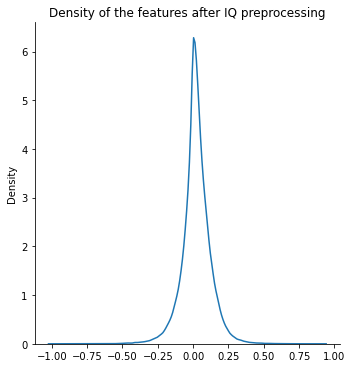

In [8]:
combined = pd.concat([df[feature] for feature in features])
# print(combined)
sns.displot(combined, kind="kde").set(title='Density of the features after IQ preprocessing')
d

In [372]:
df.shape

(29268, 19)

In [509]:
def train(models, metrics):
    results = pd.DataFrame()
    true_phi = []
    model_preds = []
    pdda_preds = []
    x_loc = []
    y_loc = []
    flag = True
    for model in models:
        print(str(model))
        for anchor in [1.0,2.0,3.0,4.0]:
            anchor_df = get_data_per_anchor(df,anchor)
            X = anchor_df[features].values
            y = anchor_df[targets].values
            gss = GroupShuffleSplit(n_splits=params["splits"], test_size=params["test_size"], random_state=params["random_state"])
            fold = 1
            for train_idx, test_idx in gss.split(X, y, groups=anchor_df.point):
                train = anchor_df.iloc[train_idx]
                test = anchor_df.iloc[test_idx]
                assert round(test.shape[0]/(train.shape[0]+test.shape[0]), 2) == params["test_size"]
                assert len(set(train.point) & set(test.point)) == 0
                X_train = train[features].values
                y_train = train[targets].values
                X_test = test[features].values
                test_location = test[location].values
                pdda_result = test[pdda_angle].values
                y_test = test[targets].values



                # learn the trainer on the train set and apply for testing set
                regr = make_pipeline(StandardScaler(), model)
                regr.fit(X_train,y_train)
                predictions = regr.predict(X_test)
                # need pointwise error for plotting using spatial_plot function
                # errors = []
                avg_mae = []
                # print(len(predictions))
                # print(pdda_result.shape)
                temp = []
                for i in range(len(predictions)):
                    model_preds.append(predictions[i])
                    # predictions.append(mean_absolute_error(y_test[i], temp))
                    pdda_preds.append(pdda_result[i][0])
                    true_phi.append(y_test[i][0])
                    x_coordinate, y_coordinate = test_location[i]
                    x_loc.append(x_coordinate)
                    y_loc.append(y_coordinate)
            # avg_mae.append(sum(errors)/len(errors))
            # temp = []
            # for metric in metrics:
            #     temp.append(metric(predictions, y_test))
            # # add r^2 error metric
            # # spatial_plot(errors, test_location)
            # # mae = sum(avg_mae)/len(avg_mae)
            # key = 'anchor'+ str(int(anchor)) + ' fold ' + str(fold)
            # # results[key] = temp
            # results[key] = pd.Series(errors)
            # errors = []
            # fold += 1
            # key2 = 'point location -fold ' + str(fold) + ' x - coordinate'
            # key3 = 'point location -fold ' + str(fold) + ' y - coordinate'
            # errors_df[key2] = pd.Series(test_location[:,0])
            # errors_df[key3] = pd.Series(test_location[:,1])
            # results[key] = pd.Series(errors)
        # results['x-coordinate for anchor'+ str(int(anchor)) + ' fold ' + str(fold)] = pd.Series(test_location[:,0])
        # results['y-coordinate for anchor'+ str(int(anchor)) + ' fold ' + str(fold)] = pd.Series(test_location[:,1])
        if flag:
            results['pdda'] = pdda_preds
            results['true_phi'] = true_phi
            results['x_loc'] = x_loc
            results['y_loc'] = y_loc
            flag = False
            
        results[str(model)] = model_preds
        model_preds = []
        # pdda_preds = []
        # true_phi = []
        # x_loc = []
        # y_loc = []
        
    return (results, regr)

In [518]:
models = [KNeighborsRegressor(), RandomForestRegressor(), SVR(), SVR(kernel='poly'), GradientBoostingRegressor(), MLPRegressor()]

metrics = [mean_absolute_error, r2_score]
# model_names = ['KNN', 'RF', 'SVR_rbf', 'SVR_poly', 'Gradient Boosting', 'MLP']
results, pipeline = train(models, metrics)
# avg_mae = np.mean(np.asarray(list(results.values()))[:,0])
# print('Average error of all anchors over all folds ' + str(avg_mae))
# results

KNeighborsRegressor()
RandomForestRegressor()
SVR()
SVR(kernel='poly')
GradientBoostingRegressor()
MLPRegressor()


In [519]:
results.head(20)

,pdda,true_phi,x_loc,y_loc,KNeighborsRegressor(),RandomForestRegressor(),SVR(),SVR(kernel='poly'),GradientBoostingRegressor(),MLPRegressor()
0,23,38.4,44.1,44.9,[24.0],24.564,24.887195,19.693958,27.744632,25.806101
1,80,38.4,44.1,44.9,[37.660000000000004],25.879,23.327846,19.933391,26.053819,28.636405
2,60,38.4,44.1,44.9,[32.12],31.573,25.109042,19.452195,26.756456,29.099620
3,53,34.3,44.1,45.9,[36.38],35.072,33.916513,20.954406,35.769602,38.648749
4,41,34.3,44.1,45.9,[38.519999999999996],37.625,41.878026,22.142247,39.592802,42.796827
5,48,34.3,44.1,45.9,[36.88],38.034,36.167973,19.890840,36.907715,38.154630
6,32,30.4,44.1,46.9,[32.42],33.669,34.479183,20.771357,33.865195,33.592904
7,29,30.4,44.1,46.9,[29.54],22.915,28.698967,20.337342,29.342052,28.733318
8,39,30.4,44.1,46.9,[32.92],36.836,35.233506,21.124719,34.822301,35.259328
9,28,28.8,44.1,47.3,[34.839999999999996],31.201,29.870329,19.829403,31.448270,29.282302


In [520]:
results.to_pickle('results.pkl')

In [512]:
mae_pdda = mean_absolute_error(results['pdda'], results['true_phi'])
mae_pdda

14.327106833626548

In [516]:
mae_knn = mean_absolute_error(results['KNeighborsRegressor()'], results['true_phi'])
mae_knn

7.522975611438821

In [517]:
mae_rf = mean_absolute_error(results['RandomForestRegressor()'], results['true_phi'])
mae_rf

7.334800303563421

In [253]:
results_df = pd.DataFrame.from_dict(results)
# results_df.drop(results_df.index[[1]], inplace=True)

def combine_folds(results_df):
    combined = pd.DataFrame()
    all_folds = pd.DataFrame()
    for model in model_names:
        for anchor in [1,2,3,4]:
            for fold in [1,2,3]:
                col_name = model + ' anchor'+str(anchor) +' fold '+str(fold)
                fold = results_df[col_name]
                all_folds = pd.concat([all_folds, fold])   
            key = model + ' anchor' + str(anchor) 
            combined[key] = all_folds
            all_folds = pd.DataFrame()
    x_folds = pd.DataFrame()
    y_folds = pd.DataFrame()
    for anchor in [1,2,3,4]:
        for fold in [1,2,3]:
            x_col_name = 'x-coordinate for anchor'+str(anchor) +' fold '+str(fold)
            y_col_name = 'y-coordinate for anchor'+str(anchor) +' fold '+str(fold)
            x_fold = results_df[x_col_name]
            y_fold = results_df[y_col_name]
            
            x_folds = pd.concat([x_folds, x_fold])   
            y_folds = pd.concat([y_folds, y_fold])   
        x_key = 'anchor' + str(anchor) +' x-coordinate'
        y_key = 'anchor' + str(anchor) +' y-coordinate'
        combined[x_key] = x_folds
        combined[y_key] = y_folds
        x_folds = pd.DataFrame()
        y_folds = pd.DataFrame()
    return combined
    
def combine_anchors(folds_combined):
    combined = pd.DataFrame()
    all_anchors = pd.DataFrame()
    for model in model_names:
        for anchor in [1,2,3,4]:
            col_name = model + ' anchor'+str(anchor)
            anchor = folds_combined[col_name]
            all_anchors = pd.concat([all_anchors, anchor]) 
        key = model
        combined[key] = all_anchors
        all_anchors = pd.DataFrame()
    return combined


In [254]:
combined = combine_folds(results_df)

In [260]:
combined.head(20)

,KNN anchor1,KNN anchor2,KNN anchor3,KNN anchor4,RF anchor1,RF anchor2,RF anchor3,RF anchor4,anchor1 x-coordinate,anchor1 y-coordinate,anchor2 x-coordinate,anchor2 y-coordinate,anchor3 x-coordinate,anchor3 y-coordinate,anchor4 x-coordinate,anchor4 y-coordinate
0,53.98,18.34,2.98,75.06,36.207,21.533,30.024,58.363,57.9,43.5,45.1,49.9,44.1,49.7,44.5,43.1
1,48.68,26.32,51.88,81.00,50.956,23.467,47.770,68.181,57.9,43.5,45.1,49.9,44.1,49.7,44.5,43.1
2,42.74,24.34,16.26,31.48,48.465,23.284,51.848,83.008,57.9,43.5,45.1,49.9,44.1,49.7,44.5,43.1
3,35.78,18.22,13.62,94.92,93.047,25.489,11.602,82.729,57.9,43.7,44.9,49.9,44.1,49.1,44.7,43.1
4,35.78,24.88,10.56,64.24,93.538,30.274,23.293,89.097,57.9,43.7,44.9,49.9,44.1,49.1,44.7,43.1
5,42.48,18.44,0.42,50.52,52.093,21.587,17.133,0.167,57.9,43.7,44.9,49.9,44.1,49.1,44.7,43.1
6,28.08,25.46,41.04,6.36,27.191,19.859,33.580,5.443,57.9,44.3,47.1,49.9,44.1,48.3,45.3,43.1
7,34.22,18.68,9.34,4.94,41.405,16.978,9.972,4.357,57.9,44.3,47.1,49.9,44.1,48.3,45.3,43.1
8,6.26,12.22,14.18,27.74,6.763,22.576,14.756,11.200,57.9,44.3,47.1,49.9,44.1,48.3,45.3,43.1
9,11.84,9.02,19.40,2.78,7.585,11.705,8.464,1.349,57.9,44.7,46.7,49.9,44.1,47.9,46.1,43.1


In [256]:
combined.describe()

,KNN anchor1,KNN anchor2,KNN anchor3,KNN anchor4,RF anchor1,RF anchor2,RF anchor3,RF anchor4,anchor1 x-coordinate,anchor1 y-coordinate,anchor2 x-coordinate,anchor2 y-coordinate,anchor3 x-coordinate,anchor3 y-coordinate,anchor4 x-coordinate,anchor4 y-coordinate
count,7254.000000,7236.000000,7254.000000,7245.000000,7254.000000,7236.000000,7254.000000,7.245000e+03,7254.000000,7254.000000,7236.000000,7236.000000,7254.000000,7254.000000,7245.000000,7245.000000
mean,6.694028,7.042507,7.980414,8.374818,6.309628,6.976365,7.884332,8.135176e+00,50.881390,46.552605,50.857629,46.522056,50.892060,46.517370,50.864058,46.539669
std,7.587166,8.051684,10.427899,10.593349,7.542096,7.695343,9.683893,1.006545e+01,4.073161,2.038323,4.040116,2.035152,4.084944,2.018999,4.064196,2.044397
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003000,8.881784e-16,44.100000,43.100000,44.100000,43.100000,44.100000,43.100000,44.100000,43.100000
25%,1.900000,1.760000,1.380000,2.340000,1.835500,1.914750,1.835250,2.433000e+00,47.300000,44.700000,47.300000,44.700000,47.300000,44.700000,47.300000,44.700000
50%,4.420000,4.520000,4.280000,5.360000,4.130500,4.568500,4.422500,5.368000e+00,50.900000,46.700000,50.700000,46.500000,50.900000,46.500000,50.700000,46.700000
75%,8.840000,9.260000,10.315000,10.700000,8.129750,9.156750,10.249000,1.044900e+01,54.500000,48.300000,54.300000,48.300000,54.500000,48.300000,54.500000,48.300000
max,97.360000,72.540000,93.120000,169.580000,112.930000,69.430000,76.596000,1.953020e+02,57.900000,49.900000,57.900000,49.900000,57.900000,49.900000,57.900000,49.900000


In [59]:
# k = pd.DataFrame(np.asarray([key for key in results.keys()]))
# u = pd.DataFrame(np.asarray(np.asarray([k[0] for k  in results.values()])))

In [60]:
# boxplot(x="day", y="total_bill", data=tips)

In [31]:
results, pipeline = train(RandomForestRegressor(), [mean_absolute_error, r2_score])
avg_mae = np.mean(np.asarray(list(results.values()))[:,0])
print('Average error of all anchors over all folds ' + str(avg_mae))
results

Average error of all anchors over all folds 7.308225714670961


{'anchor1 fold 1': [6.203946830265849, 0.7848686798055848],
 'anchor1 fold 2': [5.93059918200409, 0.823259126568694],
 'anchor1 fold 3': [6.350988411724609, 0.7820379088899118],
 'anchor1 fold 4': [6.6968745739604625, 0.7637226960791588],
 'anchor1 fold 5': [5.972214723926381, 0.793773892915123],
 'anchor2 fold 1': [6.544867214236824, 0.7361262277487861],
 'anchor2 fold 2': [7.153799452429842, 0.7122765162548457],
 'anchor2 fold 3': [6.610008898015058, 0.7633694673191136],
 'anchor2 fold 4': [6.783307323750856, 0.763285614690114],
 'anchor2 fold 5': [7.030284052019164, 0.7254857182083423],
 'anchor3 fold 1': [7.825997273346967, 0.6540277544930854],
 'anchor3 fold 2': [8.095241990456715, 0.6558295372384708],
 'anchor3 fold 3': [7.493997955010225, 0.7017531625554763],
 'anchor3 fold 4': [8.182970688479893, 0.6056842946629102],
 'anchor3 fold 5': [8.049126789366053, 0.6453800387162905],
 'anchor4 fold 1': [7.538775956284153, 0.7225829005469262],
 'anchor4 fold 2': [8.980167349726775, 0.52

In [116]:
results, pipeline = train(SVR(kernel='poly'), [mean_absolute_error, r2_score])
avg_mae = np.mean(np.asarray(list(results.values()))[:,0])
print('Average error of all anchors over all folds ' + str(avg_mae))
results

Average error of all anchors over all folds 15.081185314997887


{'anchor1 fold 1': [13.885306341557383, -0.39442859795183804],
 'anchor1 fold 2': [13.593100067728537, -0.2809046828127004],
 'anchor1 fold 3': [14.007218282909, -0.4107977684959576],
 'anchor2 fold 1': [13.679212025215575, -0.6171318281616105],
 'anchor2 fold 2': [13.896386472231535, -0.4970587090167482],
 'anchor2 fold 3': [14.563136484470348, -0.3338069647536144],
 'anchor3 fold 1': [15.8036046917779, -0.7429530274957303],
 'anchor3 fold 2': [16.87536901769621, -0.9507915362496604],
 'anchor3 fold 3': [15.523664551125414, -0.8129493035152209],
 'anchor4 fold 1': [15.775620083020588, -0.5127612911281576],
 'anchor4 fold 2': [17.135192689686345, -0.082011883940033],
 'anchor4 fold 3': [16.236413072555813, -0.24788319173679518]}

In [118]:
results, pipeline = train(SVR(), [mean_absolute_error, r2_score])
avg_mae = np.mean(np.asarray(list(results.values()))[:,0])
print('Average error of all anchors over all folds ' + str(avg_mae))
results

Average error of all anchors over all folds 9.695878272639911


{'anchor1 fold 1': [8.394195112307104, 0.5431109660586092],
 'anchor1 fold 2': [8.3987360901802, 0.5295907878760042],
 'anchor1 fold 3': [8.508721969728658, 0.527045181336518],
 'anchor2 fold 1': [9.016702793623649, 0.5052967348233179],
 'anchor2 fold 2': [9.366159192270215, 0.46133779092653626],
 'anchor2 fold 3': [9.00444476808665, 0.5373190566219159],
 'anchor3 fold 1': [10.500371104507213, 0.23520948401789887],
 'anchor3 fold 2': [11.181912689423418, 0.07825010401762555],
 'anchor3 fold 3': [10.03640200933538, 0.2857314961777948],
 'anchor4 fold 1': [10.317105979860692, 0.3657022029168916],
 'anchor4 fold 2': [11.032450392381229, 0.1621776034378406],
 'anchor4 fold 3': [10.593337169974552, 0.27955938890026777]}

In [117]:
results, pipeline = train(GradientBoostingRegressor(), [mean_absolute_error, r2_score])
avg_mae = np.mean(np.asarray(list(results.values()))[:,0])
print('Average error of all anchors over all folds ' + str(avg_mae))
results

Average error of all anchors over all folds 8.610628550164755


{'anchor1 fold 1': [7.11100144722744, 0.7561395222168258],
 'anchor1 fold 2': [7.136116383246613, 0.7425351704285925],
 'anchor1 fold 3': [7.398711312582828, 0.737231838249113],
 'anchor2 fold 1': [8.268289956488438, 0.6379421885769361],
 'anchor2 fold 2': [8.32618386220949, 0.6354484310365094],
 'anchor2 fold 3': [8.272224029269616, 0.6835918016527084],
 'anchor3 fold 1': [9.515591509155062, 0.5183891073740631],
 'anchor3 fold 2': [9.877014512242114, 0.4899145716094381],
 'anchor3 fold 3': [9.083729986334362, 0.5899004397505798],
 'anchor4 fold 1': [9.175289488562825, 0.6419613380661622],
 'anchor4 fold 2': [9.74311406523673, 0.5049481251276791],
 'anchor4 fold 3': [9.420276049421547, 0.5563889474236048]}

In [119]:
results, pipeline = train(MLPRegressor(), [mean_absolute_error, r2_score])
avg_mae = np.mean(np.asarray(list(results.values()))[:,0])
print('Average error of all anchors over all folds ' + str(avg_mae))
results

Average error of all anchors over all folds 8.66546034916322


{'anchor1 fold 1': [7.08401050620348, 0.777251387622419],
 'anchor1 fold 2': [7.2122227710828914, 0.7567512981887184],
 'anchor1 fold 3': [7.494031389751674, 0.7600748860081491],
 'anchor2 fold 1': [8.349041436605429, 0.643740215257095],
 'anchor2 fold 2': [8.39975383019016, 0.6533896226863374],
 'anchor2 fold 3': [8.477271032594182, 0.677957610344853],
 'anchor3 fold 1': [9.59467844145727, 0.5511631658892431],
 'anchor3 fold 2': [9.902025107098611, 0.504284516003903],
 'anchor3 fold 3': [9.074961532426405, 0.6098035245539439],
 'anchor4 fold 1': [9.280295394731958, 0.6416695967085795],
 'anchor4 fold 2': [9.640288279492776, 0.5241786637209171],
 'anchor4 fold 3': [9.476944468323795, 0.5564721103110171]}

In [ ]:
#XGBOOST, simple MPLS, (different kernels for svm),
# decision trees, adaboost, 
# show errors for cross validation
# show distribution of errors
# plot this on the exact room
# average error for all anchors for each point
# plot the distribution of iq values
# scale the whole dataset if it is not already scaled 
# learn scaler for each fold and apply for test 


In [ ]:
# 1. formalize keras pipeline, correct filter size and stride, specific architecture that makes use of IQ features
# 2. how simulation dataset should look like? extend the dataset to different scenarions, different rooms with different dimensions
